In [2]:
import numpy as np

In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',version=1)
mnist.keys()
X,y = mnist['data'], mnist['target']

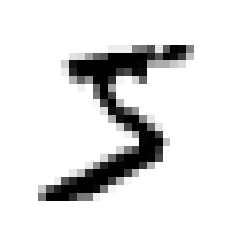

In [4]:
import matplotlib as mlt
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)


plt.imshow(some_digit_image,cmap='binary')
plt.axis('off')
plt.show()

In [5]:
y[0]

'5'

In [6]:
#将y转成整数
y = y.astype(np.uint8)

In [7]:
#mnist 以及将数据机分成了训练集与测试集
X_train,X_test, y_train, y_test = X[:60000], X[60000:] ,y[:60000], y[60000:]


In [8]:
#训练一个简单的二元分类问题
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

#使用随机梯度下降分类器
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)


SGDClassifier(random_state=42)

In [9]:
sgd_clf.predict([some_digit])

array([ True])

In [10]:
#性能测量
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3,random_state=42)

for train_index ,test_index in skfolds.split(X_train,y_train_5):
    clone_clf = clone(sgd_clf)
    x_train_fold = X_train[train_index]
    y_train_fold = y_train_5[train_index]

    x_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    clone_clf.fit(x_train_fold,y_train_fold)
    y_pred = clone_clf.predict(x_test_fold)
    n_correct = sum(y_test_fold == y_pred)
    print( n_correct/len(y_pred))
#或者使用cross_val_score,效果相同
# from sklearn.model_selection import cross_val_score
# cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring='accuracy')

0.95035
0.96035
0.9604


In [11]:
#正确率都超过了95%，能否说明分类效果很好；
#创建一个全部预测为False的分类器，看看效果；
#可以发现准确率仍然有90%

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self,X,y=None):
        return self
    def predict(self,X):
        return np.zeros((len(X),1),dtype= bool)

never5Classifier = Never5Classifier()
from sklearn.model_selection import cross_val_score
cross_val_score(never5Classifier,X_train,y_train_5,cv=3,scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

In [12]:
#混淆矩阵
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf,X_train, y_train_5,cv=3)
#计算混淆矩阵，需要一组预测与实际目标进行比较


In [13]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,y_train_pred)



array([[53892,   687],
       [ 1891,  3530]])

In [14]:
#TN FP
#FN TP
#一个完美的分类器，将只有TN与TP；
confusion_matrix(y_train_5,y_train_5)

array([[54579,     0],
       [    0,  5421]])

In [15]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [16]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [17]:
# 精度为所有正类预测的准确率
# 可以发现精度和召回率都是不是那么好；
# 可以将精度和召回率合并为一个指标，这就是F1分数；
# F1分数是精度和召回率的谐波平均值，谐波平均值对较低的值具有更高的权重，所以只有当两个参数都很高时才能获得较高的分数；
from sklearn.metrics import f1_score
f1_score(y_train_5,y_train_pred)

0.7325171197343846

In [18]:
# 遗憾的是鱼与熊掌不可兼得；
# 精度/召回率权衡
# 通过decision_function获得决策分数，在用一个阈值去调整
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [19]:
threshold = 0
some_digit_pred = [y_scores > threshold]
some_digit_pred

[array([ True])]

In [20]:
y_scores = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method='decision_function')
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

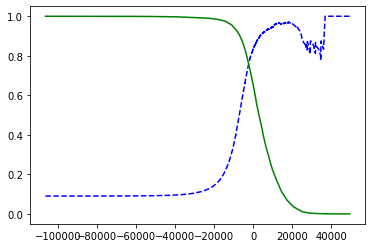

In [21]:

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1],'b--',label='Precision')
    plt.plot(thresholds, recalls[:-1],'g-',label='Recall')
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [22]:
# 一个90%精度的阈值
threshold_90_precision = thresholds[np.argmax(precisions>=0.9)]
y_train_90_pred = (y_scores >= threshold_90_precision)

In [23]:
precision_score(y_train_5,y_train_90_pred)

0.9000345901072293

In [24]:
recall_score(y_train_5, y_train_90_pred)

0.4799852425751706

In [25]:
# roc曲线
from sklearn.metrics import roc_curve

fpr ,tpr, thresholds = roc_curve(y_train_5, y_scores)



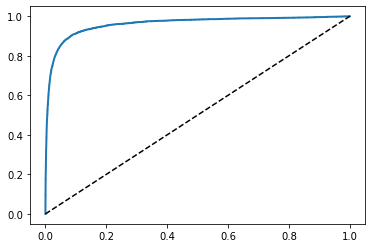

In [30]:
def plot_roc_curve(fpr ,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--')
plot_roc_curve(fpr ,tpr)
plt.show()

In [27]:
# auc 为roc线下的面积
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

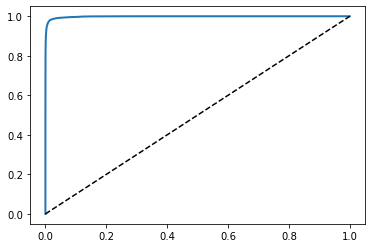

In [28]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)

y_probas_forest = cross_val_predict(forest_clf,X_train,y_train_5,cv=3,method='predict_proba')
y_socres_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_socres_forest)



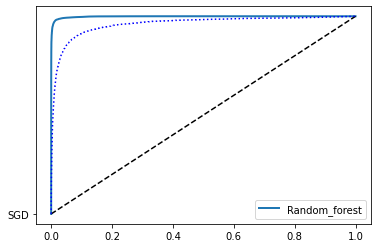

In [35]:
plot_roc_curve(fpr_forest,tpr_forest,'Random_forest')
plt.plot(fpr,tpr,'b:','SGD')
plt.legend(loc='lower right')
plt.show()

In [33]:
roc_auc_score(y_train_5, y_socres_forest)

0.9983436731328145

In [36]:
y_train_forest_pred = cross_val_predict(forest_clf,X_train,y_train_5,cv=3)
precision_score(y_train_5, y_train_forest_pred)

0.9905083315756169

In [37]:
recall_score(y_train_5, y_train_forest_pred)

0.8662608374838591

In [39]:
# 多类分类器
# 一些算法直接可以处理多类分类，一些严格的二元分类算法也可以通过一些策略转换为多类分类器；
# 对于将数字图片分为10类的问题；
# 一对剩余策略OvR，训练10个二元分类器（0-剩余，1-剩余...） 选择分数最高的类最为类别
# 一对一策略OvO，需要训练45个二元分类器，（N*（N-1）/2）最后看哪个类获胜最多
# scikit-learn会自动运行OvR或OvO

from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [45]:
some_digit_socres = svm_clf.decision_function([some_digit])
np.argmax(some_digit_socres)
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
# 强制使用一对一或一对多策略；
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])


In [47]:
# 误差分析
y_train_pred =  cross_val_predict(sgd_clf,X_train,y_train,cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5860,   63,    0,    0,    0,    0,    0,    0,    0,    0],
       [6675,   67,    0,    0,    0,    0,    0,    0,    0,    0],
       [5932,   26,    0,    0,    0,    0,    0,    0,    0,    0],
       [5913,  218,    0,    0,    0,    0,    0,    0,    0,    0],
       [5821,   21,    0,    0,    0,    0,    0,    0,    0,    0],
       [1891, 3530,    0,    0,    0,    0,    0,    0,    0,    0],
       [5796,  122,    0,    0,    0,    0,    0,    0,    0,    0],
       [6251,   14,    0,    0,    0,    0,    0,    0,    0,    0],
       [5741,  110,    0,    0,    0,    0,    0,    0,    0,    0],
       [5903,   46,    0,    0,    0,    0,    0,    0,    0,    0]])

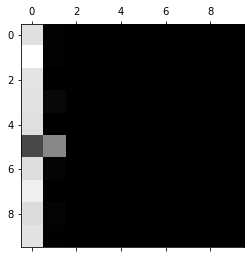

In [48]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [50]:
row_sums = conf_max.sum(axis=1,keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx,cmap=plt.cm.gray)
plt.show()

NameError: name 'conf_max' is not defined

In [ ]:
# 多标签分类，多输出分类；
# 多标签分类为一个实例有多个二元标签的分类系统，多输出分类是多标签分类的推广，
# 每个实例将会有多个输出类别，即标签也是多个类别的
from sklearn.neighbors import KNeighborsClassfier
y_train_large = (y_train >= 7)
y_train_odd = (y_train %2 == 1)
y_multilabel = np.c_(y_train_large,y_train_odd)

knn_clf = KNeighborsClassfier()
knn_clf.fit(X_train,y_multilabel)
knn_clf.predict([some_digit])